In [1]:
import numpy as np
import pandas as pd

## 4.18
### a

In [2]:
mystery = pd.read_csv('./data/mysteries.csv')
mystery_group = mystery.groupby("stratum")

In [3]:
male_female_h = np.array(
    mystery_group["authorgender"]\
    .sum()\
    .apply(lambda x: [x.count("M") / len(x), x.count("F") / len(x)])\
    .tolist()
)
weights = mystery_group["p1weight"].mean()

In [4]:
x_bar = (male_female_h[:, 1] * weights).sum()
y_bar = (male_female_h[:, 0] * weights).sum()
b_hat =  y_bar / x_bar

In [5]:
ei = mystery["authorgender"].apply(lambda y: (y.count("M") - b_hat * y.count("F")) ** 2)
fpc = 1/60 - 1/655
b_hat_var = (ei * weights).var(ddof=1) * fpc / (x_bar ** 2)

In [6]:
b_hat_ci = np.array([b_hat - 1.96 * np.sqrt(b_hat_var), b_hat + 1.96 * np.sqrt(b_hat_var)])
print(f"b_hat: {b_hat}")
print(f"b_hat_var: {b_hat_var}")
print(f"b_hat_ci: {b_hat_ci}")

b_hat: 2.207505518781457
b_hat_var: 0.00145783268500254
b_hat_ci: [2.13266963 2.28234141]


### b

In [7]:
md_t = mystery["mdetect"] * mystery["p1weight"]
fd_t = mystery["fdetect"] * mystery["p1weight"]

In [8]:
b_hat = fd_t.sum() / md_t.sum()

In [9]:
ei = mystery["mdetect"] - b_hat * mystery["fdetect"]
b_hat_var = (ei * mystery["p1weight"]).var(ddof=1) * fpc / ((fd_t.sum()/60) ** 2)

In [10]:
b_hat_ci = np.array([b_hat - 1.96 * np.sqrt(b_hat_var), b_hat + 1.96 * np.sqrt(b_hat_var)])
print(f"b_hat: {b_hat}")
print(f"b_hat_ci: {b_hat_ci}")

b_hat: 0.2558364582053497
b_hat_ci: [-0.67775425  1.18942716]


## 2补充

### a

In [11]:
agpop = pd.read_csv('./data/agpop.csv')
agstrat = pd.read_csv('./data/agstrat.csv')

In [12]:
agpop_region = agpop.groupby("region")
agstrat_region = agstrat.groupby("region")

In [13]:
xhu_bar = agpop_region["acres87"].mean()
x_u_bar = agpop["acres87"].mean()
print(f"xhu_bar: {xhu_bar}")
print(f"x_u_bar: {x_u_bar}")

xhu_bar: region
NC    332487.292220
NE    100126.845455
S     203019.015195
W     735598.627962
Name: acres87, dtype: float64
x_u_bar: 313016.37816764135


### b
* 分别比估计

In [14]:
N = agpop.shape[0]
n_h = agstrat_region["acres87"].count()
N_h = agpop_region["acres87"].count()
W_h = N_h / N
fpc_h = 1/n_h - 1/N_h

In [15]:
b_h_hat = agstrat_region["acres92"].sum() / agstrat_region["acres87"].sum()

In [16]:
y_rs_bar = 1/N * np.sum(b_h_hat * agpop_region["acres87"].sum())

In [17]:
y_rs_bar_var = np.sum(
    W_h ** 2 * fpc_h *
    (
            agstrat_region["acres92"].var(ddof=1)
            - 2 * b_h_hat * agstrat_region[["acres87", "acres92"]].apply(lambda x: x['acres87'].cov(x['acres92'], ddof=1))
            + b_h_hat ** 2 * agstrat_region["acres87"].var(ddof=1)
    )
)

In [18]:
y_rs_bar_ci = np.array([y_rs_bar - 1.96 * np.sqrt(y_rs_bar_var), y_rs_bar + 1.96 * np.sqrt(y_rs_bar_var)])
print(f"y_rs_bar: {y_rs_bar}")
print(f"y_rs_bar_var: {y_rs_bar_var}")
print(f"y_rs_bar_se: {np.sqrt(y_rs_bar_var)}")
print(f"y_rs_bar_ci: {y_rs_bar_ci}")

y_rs_bar: 310050.0749555694
y_rs_bar_var: 3277183.202007093
y_rs_bar_se: 1810.2992023439365
y_rs_bar_ci: [306501.88851898 313598.26139216]


* 联合比估计

In [19]:
b_hat = np.sum(N_h * agstrat_region["acres92"].sum()) / np.sum(N_h * agstrat_region["acres87"].sum())

In [20]:
y_rc_bar = b_hat * x_u_bar

In [21]:
y_rc_bar_var = np.sum(
    W_h ** 2 * fpc_h *
    (
            agstrat_region["acres92"].var(ddof=1)
            - 2 * b_hat * agstrat_region[["acres87", "acres92"]].apply(lambda x: x['acres87'].cov(x['acres92'], ddof=1))
            + b_hat ** 2 * agstrat_region["acres87"].var(ddof=1)
    )
)

In [22]:
y_rc_bar_ci = np.array([y_rc_bar - 1.96 * np.sqrt(y_rc_bar_var), y_rc_bar + 1.96 * np.sqrt(y_rc_bar_var)])
print(f"y_rc_bar: {y_rc_bar}")
print(f"y_rc_bar_var: {y_rc_bar_var}")
print(f"y_rc_bar_se: {np.sqrt(y_rc_bar_var)}")
print(f"y_rc_bar_ci: {y_rc_bar_ci}")

y_rc_bar: 309305.8056693079
y_rc_bar_var: 3422373.3277662937
y_rc_bar_se: 1849.9657639443747
y_rc_bar_ci: [305679.87277198 312931.73856664]


### c
* 分别回归估计

In [23]:
b_1h_hat = agstrat_region[["acres87", "acres92"]].apply(lambda x: x['acres87'].cov(x['acres92'], ddof=1)) / agstrat_region["acres87"].var(ddof=1)

In [24]:
y_h_bar = agstrat_region["acres92"].mean()
x_h_bar = agstrat_region["acres87"].mean()
y_reg_s_bar = np.sum(W_h * (y_h_bar + b_1h_hat * (xhu_bar - x_h_bar)))

In [25]:
y_reg_s_bar_var = np.sum(
    W_h ** 2 * fpc_h * agstrat_region["acres92"].var(ddof=1) *
    (
            1 - agstrat_region[["acres87", "acres92"]].apply(lambda x: x['acres87'].corr(x['acres92']))
    )
)

In [26]:
y_reg_s_bar_ci = np.array([y_reg_s_bar - 1.96 * np.sqrt(y_reg_s_bar_var), y_reg_s_bar + 1.96 * np.sqrt(y_reg_s_bar_var)])
print(f"y_reg_s_bar: {y_reg_s_bar}")
print(f"y_reg_s_bar_var: {y_reg_s_bar_var}")
print(f"y_reg_s_bar_se: {np.sqrt(y_reg_s_bar_var)}")
print(f"y_reg_s_bar_ci: {y_reg_s_bar_ci}")

y_reg_s_bar: 310511.97728841845
y_reg_s_bar_var: 1581589.5853079702
y_reg_s_bar_se: 1257.6126531281284
y_reg_s_bar_ci: [308047.05648829 312976.89808855]


* 联合回归估计

In [27]:
b_1_hat = (
        np.sum(
            W_h ** 2 * fpc_h *
            agstrat_region[["acres87", "acres92"]].apply(lambda x: x['acres87'].cov(x['acres92'], ddof=1))
        ) /
        np.sum(
            W_h ** 2 * fpc_h *
            agstrat_region["acres87"].var(ddof=1)
        )
)

In [28]:
y_str_bar = np.sum(agstrat_region["acres92"].mean() * W_h)
x_str_bar = np.sum(agstrat_region["acres87"].mean() * W_h)
y_reg_c_bar = y_str_bar + b_1_hat * (x_u_bar - x_str_bar)

In [29]:
y_reg_c_bar_var = np.sum(
    W_h ** 2 * fpc_h *
    (
            agstrat_region["acres92"].var(ddof=1)
            - 2 * b_1_hat * agstrat_region[["acres87", "acres92"]].apply(lambda x: x['acres87'].cov(x['acres92'], ddof=1))
            + b_1_hat ** 2 * agstrat_region["acres87"].var(ddof=1)
    )
)

In [30]:
y_reg_c_bar_ci = np.array([y_reg_c_bar - 1.96 * np.sqrt(y_reg_c_bar_var), y_reg_c_bar + 1.96 * np.sqrt(y_reg_c_bar_var)])
print(f"y_reg_c_bar: {y_reg_c_bar}")
print(f"y_reg_c_bar_var: {y_reg_c_bar_var}")
print(f"y_reg_c_bar_se: {np.sqrt(y_reg_c_bar_var)}")
print(f"y_reg_c_bar_ci: {y_reg_c_bar_ci}")

y_reg_c_bar: 310014.99012591864
y_reg_c_bar_var: 3391330.4534413912
y_reg_c_bar_se: 1841.5565300694386
y_reg_c_bar_ci: [306405.53932698 313624.44092485]


### d

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

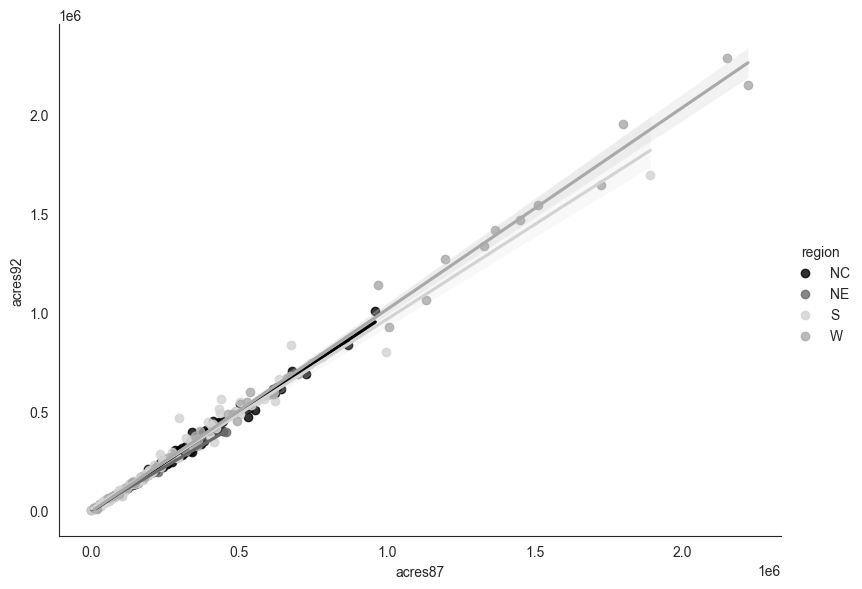

In [32]:
sns.set_style("white")
sns.lmplot(
    x="acres87",
    y="acres92",
    data=agstrat,
    hue="region",
    palette=['black', 'dimgrey', 'lightgrey', 'darkgrey'],
    height=6,
    aspect=8/6
)
plt.savefig("figure/9_2d.pdf")

## 5.8.11
### a

In [33]:
errors = np.array([4, 3, 2, 1, 0])
M = 215
error_rate = errors / M
number_error = np.array([1, 1, 4, 22, 57])
error_rate_all = np.repeat(error_rate, number_error)
error_all = np.repeat(errors, number_error)
n = np.sum(number_error)
N = 828
fpc = 1/n - 1/N

In [34]:
p_bar = 1/n * np.sum(number_error * error_rate)
print(f"p_bar: {p_bar}")

p_bar: 0.0020246238030095756


In [35]:
p_bar_var = fpc * 1/(n-1) * np.sum((error_rate_all - p_bar)**2)
p_bar_se = np.sqrt(p_bar_var)
print(f"p_bar_var: {p_bar_var}")
print(f"p_bar_se: {p_bar_se}")

p_bar_var: 1.2749751318442425e-07
p_bar_se: 0.0003570679391718392


In [36]:
t_hat = N / n * np.sum(error_all)
t_hat_se = p_bar_se * N * M
print(f"t_hat: {t_hat}")
print(f"t_hat_se: {t_hat_se}")

t_hat: 360.42352941176466
t_hat_se: 63.565234531370805


In [37]:
v_p_srs = (1 - n/N) / (n * M - 1) * p_bar * (1 - p_bar)
print(f"v_p_srs: {v_p_srs}")

v_p_srs: 9.921766922548389e-08
